# GoEmotions: Dataset Exploration

This notebook loads the GoEmotions dataset and explores the label distribution, co-occurrence patterns, and example comments.

In [8]:
# Install dependencies if needed
!pip install datasets pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load GoEmotions (raw split — multi-label annotations)
ds = load_dataset("google-research-datasets/go_emotions", "raw")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'],
        num_rows: 211225
    })
})


In [10]:
# Convert to DataFrames and save CSVs
print("Available splits:", list(ds.keys()))

df_all = ds["train"].to_pandas()

# Manual split: 80% train, 10% validation, 10% test
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
n = len(df_all)
df_train = df_all.iloc[:int(n * 0.8)]
df_valid = df_all.iloc[int(n * 0.8):int(n * 0.9)]
df_test  = df_all.iloc[int(n * 0.9):]

df_train.to_csv("artifacts/goemotions_train.csv", index=False)
df_valid.to_csv("artifacts/goemotions_validation.csv", index=False)
df_test.to_csv("artifacts/goemotions_test.csv", index=False)

print(f"Train: {len(df_train)} | Validation: {len(df_valid)} | Test: {len(df_test)}")
df_train.head()

Available splits: ['train']
Train: 168980 | Validation: 21122 | Test: 21123


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Literally everywhere. There's nothing especial...,eeochpb,KyleG,texas,t3_aiibrx,t1_eeo49lo,1.548139e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,0
1,"[NAME] and [NAME] may be stronger, but [NAME] ...",eewnhep,King_Jorza,freefolk,t3_ajihmn,t3_ajihmn,1.548397e+09,16,False,0,...,0,0,0,0,0,0,0,0,0,1
2,Ik I’m crying rn,ee4utnt,lloydness21,Paladins,t3_agaxxw,t1_ee4tpmc,1.547575e+09,76,False,0,...,0,0,0,0,0,0,0,1,0,0
3,"He was cut yesterday, unfortunately",effsrc0,goat_mule,detroitlions,t3_alltop,t1_effqbes,1.548942e+09,23,False,0,...,0,0,0,0,0,0,0,0,0,1
4,"Nice, I saw them during the Demo and was prett...",ee579yx,LeiaOrgasma,socialism,t3_agb8m7,t1_ee56s9i,1.547583e+09,62,False,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# Original 28 labels (27 emotions + neutral)
ORIGINAL_LABELS = [
    'admiration','amusement','anger','annoyance','approval','caring','confusion',
    'curiosity','desire','disappointment','disapproval','disgust','embarrassment',
    'excitement','fear','gratitude','grief','joy','love','nervousness','optimism',
    'pride','realization','relief','remorse','sadness','surprise','neutral'
]

# Mapping to our 7-class taxonomy
LABEL_MAP_7 = {
    'anger':['anger','annoyance','disapproval'],
    'disgust':['disgust'],
    'fear':['fear','nervousness'],
    'joy':['joy','amusement','approval','excitement','gratitude','love','optimism','pride','relief','admiration'],
    'neutral':['neutral','realization'],
    'sadness':['sadness','disappointment','grief','remorse','embarrassment'],
    'surprise':['surprise','confusion','curiosity','desire','caring']
}

print("Mapping defined.")

Mapping defined.


Columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


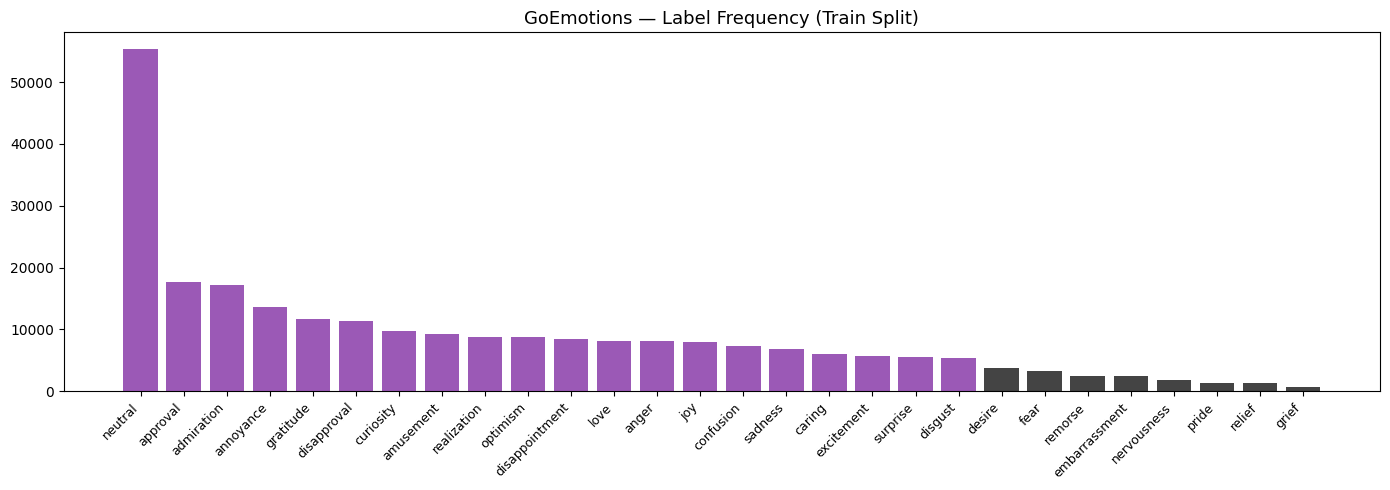

In [12]:
# Label frequency distribution (original 28)
# In the raw config each emotion is its own column (0/1), not a "labels" list
print("Columns:", df_all.columns.tolist())

label_counts = {label: int(df_all[label].sum()) for label in ORIGINAL_LABELS if label in df_all.columns}

counts_series = pd.Series(label_counts).sort_values(ascending=False)

plt.figure(figsize=(14, 5))
colors = ['#9B59B6' if c > 5000 else '#444' for c in counts_series.values]
plt.bar(counts_series.index, counts_series.values, color=colors)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.title("GoEmotions — Label Frequency (Train Split)", fontsize=13)
plt.tight_layout()
plt.savefig("artifacts/label_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Print example comments per emotion
for emotion_7, sub_labels in LABEL_MAP_7.items():
    print(f"\n=== {emotion_7.upper()} ===")
    count = 0
    for _, row in df_all.iterrows():
        if any(row.get(sub, 0) == 1 for sub in sub_labels):
            print(f"  → {str(row['text'])[:120]}")
            count += 1
            if count >= 3:
                break


=== ANGER ===
  → Minus the eyebrows I personally think it’s an attractive look. But the fucking eyebrows ruin it all.
  → But he was so *hurt* when [NAME] acknowledged that homosexuality is a sin.
  → Well she played a damn long game with this 'Publicity Stunt' seeing as it was 10 years ago

=== DISGUST ===
  → Direct democracy is a terrible idea. People are morons who's opinions are easily manipulated.
  → I'm not sure honestly. I think there's a fanmade audiobook but I've heard it's pretty bad. Sorry.
  → I'm always paranoid of people following me when I am driving home. I would have pooed my pants yikes.

=== FEAR ===
  → Demonize - to portray as wicked and threatening. It's not hard to demonize someone when they regularly demonize themselv
  → I'm always paranoid of people following me when I am driving home. I would have pooed my pants yikes.
  → Not sure about OP, but caffeine tends to make many people more anxious (especially those with a co-morbid anxiety disord

=== JOY ===
